In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
from sklearn.model_selection import cross_val_predict, GridSearchCV



file = r'C:\Users\Carlos\Documents\UPM\Máster\MLL\Half-Term-OSA-Python-master\DATA\OSA_DB_final.xlsx'
# Load spreadsheet
xl = pd.ExcelFile(file)

# Print the sheet names
print(xl.sheet_names)

['Sheet1']


In [110]:
# Load a sheet into a DataFrame by name: df_OSA_extreme
df_OSA = xl.parse('Sheet1')
df_OSA.head(5)

,Patient,Gender,IAH,Peso,Talla,IMC,Edad,PerCervical,Fumador,Enfermedades,OSA
0,P0004,1,19.7,78,1.68,27.636054,39,42.0,0,1,Medium
1,P0005,1,9.0,80,1.73,26.729927,32,40.0,0,1,Healthy
2,P0006,1,2.0,109,1.90,30.193906,32,42.0,0,1,Healthy
3,P0007,1,34.0,86,1.69,30.110991,39,42.0,0,1,Severe
4,P0008,1,60.0,145,1.72,49.012980,47,44.0,0,1,Severe


In [111]:

#Transform the OSA column into integers so that it can be processed by the model.
def fun(x):
    if x=='Healthy':
        return 0
    elif x=='Medium':
        return 1
    elif x=='Severe':
        return 2
OSA=df_OSA['OSA'].apply(fun)
df_OSA['OSA']=OSA

In [19]:
#df_OSA=df_OSA.loc[df_OSA['OSA']!=2]

In [112]:
x_features = ["Edad","PerCervical","Peso", 'IMC', 'Gender']
X = df_OSA[x_features] 
y = df_OSA["OSA"]
model = RandomForestClassifier()

In [113]:
parameters = {  'alpha':[ 2, 5,10, 100, 1000, 10000,100000,1000000]}
clf = GridSearchCV(model, parameters, cv=10)
clf.fit(X,y)
clf.best_params_

ValueError: Invalid parameter alpha for estimator RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False). Check the list of available parameters with `estimator.get_params().keys()`.

In [115]:
 
model=RandomForestClassifier(n_estimators=500)
#y_score= cross_val_predict(model,X,y,cv=10,method='decision_function')
y_score= cross_val_predict(model,X,y,cv=10,method='predict_proba')
#y_score=y_score[:,1] #predicción de la probabilidad de la clase positiva
#y_score=np.reshape(y_score, [len(y_score), 1])
print(y_score.shape)

acc=accuracy_score(y, y_pred)
recall=recall_score(y, y_pred, average='macro') 
prec=precision_score(y, y_pred, average='macro')
f1=f1_score(y, y_pred, average='macro')




(621, 3)


In [116]:
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]
for i in range(3):
    roc=roc_auc_score(y[:,i], y_score[:,i])
    print(roc)


0.733276416231
0.523922967822
0.698440453686


In [117]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [118]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [119]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])    

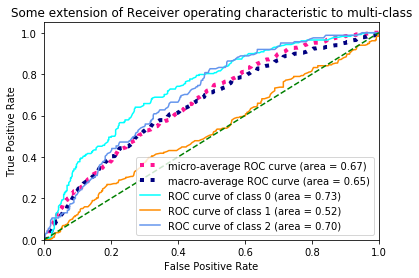

In [120]:
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'g--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [109]:
print(acc) 
print( recall)
print(prec)
print( f1)

0.50885668277
0.479724893193
0.51912568306
0.468972020801
